<center><font size="5"><b>Causal AI: <br> Causal Impact of Player Substitutions on Soccer Team Performance <br> Wasserstein-GAN <br> <a href="https://doi.org/10.1016/j.jeconom.2020.09.013">(Athey et al., 2024)</a></b></font></center>

In [1]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# --- GAN stuff:
import torch
from scipy.stats import wasserstein_distance
import copy



In [2]:
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
seed = sum(map(ord, "eda-simulation"))
rng = np.random.default_rng(seed)

In [3]:
def R2(y,yhat,ybar):

    SSR = sum((y-yhat)**2)
    SST = sum((y-ybar)**2)
    return 1 - SSR/SST
    

In [4]:
# =================================== USER INTERACTION -- Global Parameters =================================== #

# -------------------------------- Data -------------------------------- #


# --- Path to the main directory: [None; str]
directory = '/Users/maximilian/Dropbox/Max/52_SoccerCausality' 


# -------------------------------- Model -------------------------------- #

# --- Select the outcomes (Y) that you want to analyze the causal drivers of: ['shots','goals','passes']
OUTCOMES = ["shots","goals","passes"]


# -------------------------------- Figures -------------------------------- #

# --- Want to save the figures? [True; False]
SAVE_FIG = False

# =================================== USER INTERACTION -- Global Parameters =================================== #

<br>

## 00. &emsp; Auxiliaries

In [5]:
class Scaler():

    # ======================================== Scale the Numerical Features ======================================== #

    def standardize(df, mu=0,sigma=1,verbose=True):

        if verbose:
            print(f'\n[SCALING]: You chose option STANDARDIZATION. Your continuous features will have mean={mu} and standard-deviation={sigma} .')
    
        
        # --- Get the mean of the Training-Set:
        scale_vars_mean = np.mean(df, axis=0)
    
        # --- Get the standard-deviation of the Training-Set:
        scale_vars_sd = np.std(df, axis=0) * (1/sigma)
    
        # --- Scale the data:
        df = (df - scale_vars_mean) / scale_vars_sd + mu


        return {'df':df,'numerator':scale_vars_mean,'denominator':scale_vars_sd,'bias':mu}
    
    
    def minmax(df,verbose=True):

        if verbose:
            print(f'\n[SCALING]: You chose option MIN-MAX. ALL features will have min=0 & max=1.')
    
        # --- Get the maximum of the Training-Set:
        scale_vars_max = np.max(df, axis=0)
    
        # --- Get the minimum of the Training-Set:
        scale_vars_min = np.min(df, axis=0)
    
        # --- Scale the data:
        df = (df - scale_vars_min) / (scale_vars_max - scale_vars_min)


        return {'df':df,'numerator':scale_vars_min,'denominator':(scale_vars_max - scale_vars_min),'bias':0}




<br>

## 00. &emsp; Data Loading / Simulation

In [6]:
# =================================== 00.1 Load the Data =================================== #

# --- Read in the Data:
df = pd.read_csv(f'{directory}/10_data/data_StatsBomb__byMatch_bySub.csv').astype({'match_id':int})
    

# --- Number of Matches with Substitutions:
matchID__Sub = list(df.loc[df['substitution_replacementNumber__off'].dropna().index,:]['match_id'].unique())

print(f"\n# Match Situations:    {df.shape[0]}")
print(f"# Unique Matches:      {len(df['match_id'].unique())}")
print(f"# Matches with Sub:    {len(matchID__Sub)}")
print(f"Matches with Subs (%): {len(matchID__Sub) / len(df['match_id'].unique()) * 100:.2f}%")
print("\n")
df.head()


# Match Situations:    4950
# Unique Matches:      2327
# Matches with Sub:    2210
Matches with Subs (%): 94.97%




,match_status,match_id,competition,season,team_off,team_off__id,team_def,team_def__id,team_off__score60,team_def__score60,...,shots_target__def__pre,shots_target__def__post,goals_scored__off__pre,goals_scored__off__post,goals_scored__def__pre,goals_scored__def__post,substitution_tactical__off__pre,substitution_tactical__off__post,substitution_tactical__def__pre,substitution_tactical__def__post
0,3888704__59,3888704,International - FIFA World Cup,1958,France,771.0,Brazil,781.0,1.0,3.0,...,17.0,10.0,1.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0
1,3888705__59,3888705,International - FIFA World Cup,1958,Sweden,790.0,Brazil,781.0,1.0,3.0,...,11.0,4.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0
2,3888854__59,3888854,International - FIFA World Cup,1962,Mexico,794.0,Brazil,781.0,0.0,1.0,...,13.0,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,3888699__76,3888699,International - FIFA World Cup,1970,Czechoslovakia,17469.0,Brazil,781.0,1.0,2.0,...,14.0,2.0,1.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0
4,3888700__62,3888700,International - FIFA World Cup,1970,England,768.0,Brazil,781.0,0.0,1.0,...,8.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# =================================== 00.2 For Compatibility further down the Road =================================== #

# --- Score Differential in Minute 60:
df['score_diff'] = df['team_off__score60'] - df['team_def__score60']

# --- Indicator whether a substitution was made or not:
df['sub'] = np.where(df['match_id'].isin(matchID__Sub),1,0)


# --- Outcomes per Minute, pre- & post-event:
for team in ['off','def']:

    # --- Passes per Minute:
    df[f'passes_perMin__{team}__pre'] = df[f'passes_total__{team}__pre'] / df['substitution_minute__off']
    df[f'passes_perMin__{team}__post'] = df[f'passes_total__{team}__post'] / df['substitution_minuteDelta__off']
    
    # --- Shots per Minute:
    df[f'shots_perMin__{team}__pre'] = df[f'shots_total__{team}__pre'] / df['substitution_minute__off']
    df[f'shots_perMin__{team}__post'] = df[f'shots_total__{team}__post'] / df['substitution_minuteDelta__off']
    
    # --- Goals per Minute:
    df[f'goals_perMin__{team}__pre'] = df[f'goals_scored__{team}__pre'] / df['substitution_minute__off']
    df[f'goals_perMin__{team}__post'] = df[f'goals_scored__{team}__post'] / df['substitution_minuteDelta__off']


# --- Strength Differential Passes:
df['strength_diff__passes'] = df['passes_total__off__pre'] - df['passes_total__def__pre']

# --- Strength Differential Shots:
df['strength_diff__shots'] = df['shots_total__off__pre'] - df['shots_total__def__pre']

# --- Strength Differential Goals:
df['strength_diff__goals'] = df['goals_scored__off__pre'] - df['goals_scored__def__pre']


# --- Offense Passes per Minute - Differential:
df['passes_perMin__off__DIFF' ] = df['passes_perMin__off__post'] - df['passes_perMin__off__pre']

# --- Offense Shots on Target per Minute - Differential:
df['shots_perMin__off__DIFF' ] = df['shots_perMin__off__post'] - df['shots_perMin__off__pre']

# --- Offense Goals per Minute - Differential:
df['goals_perMin__off__DIFF' ] = df['goals_perMin__off__post'] - df['goals_perMin__off__pre']



/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_72879/293424576.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['score_diff'] = df['team_off__score60'] - df['team_def__score60']
/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_72879/293424576.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub'] = np.where(df['match_id'].isin(matchID__Sub),1,0)
/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_72879/293424576.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [8]:
# =================================== 00.3 Features that could influence Strength-Differential =================================== #


[c.split('__off__pre')[0] for c in df.columns if '__off__pre' in c]

['clearances_total',
 'dribble_total',
 'dribble_success',
 'duel_total',
 'duel_success',
 'fouls_committed',
 'interceptions_total',
 'interceptions_success',
 'pass_shot_assist',
 'pass_goal_assist',
 'pass_success_length__total',
 'pass_success_length__0_5',
 'pass_success_length__5_10',
 'pass_success_length__10_20',
 'pass_success_length__20_40',
 'pass_success_length__40',
 'passes_total',
 'passes_success',
 'shots_total',
 'shots_target',
 'goals_scored',
 'substitution_tactical',
 'passes_perMin',
 'shots_perMin',
 'goals_perMin']

In [9]:
# ==================================== Pre-& Post-Substitution Differentials ==================================== #

"""
    Instead of looking at 'totals', we now compute:
        
        (i)  success rates, and 
        (ii) build a composite index of team-strength, composed of the success rates of
             (ii.a) passes
             (ii.b) shots
             (ii.c) duels
             (ii.d) interceptions
             (ii.e) dribbles

    ... for pre- & post-event segments.
             
"""



# --------------------------------- USER INTERACTION --------------------------------- #

# --- Weighting of Performance Components: [numbers have to sum up to 1!]
wPerformance = {'passes':0.2,'shots':0.2,'duels':0.2,'interceptions':0.2,'dribbles':0.2}

# --------------------------------- USER INTERACTION --------------------------------- #




for sub in ['pre','post']:

    # --- Strength Diff Rate Passes:
    df[f'pass_success_Rate__off__{sub}'] = (df[f'pass_success_length__0_5__off__{sub}'] + df[f'pass_success_length__5_10__off__{sub}'] +
                                        df[f'pass_success_length__10_20__off__{sub}'] + df[f'pass_success_length__20_40__off__{sub}'] +
                                        df[f'pass_success_length__40__off__{sub}']) / df[f'pass_success_length__total__off__{sub}']
    df[f'pass_success_Rate__def__{sub}'] = (df[f'pass_success_length__0_5__def__{sub}'] + df[f'pass_success_length__5_10__def__{sub}'] +
                                        df[f'pass_success_length__10_20__def__{sub}'] + df[f'pass_success_length__20_40__def__{sub}'] +
                                        df[f'pass_success_length__40__def__{sub}']) / df[f'pass_success_length__total__def__{sub}']
    
    # --- Strength Diff Rate Shots:
    df[f'shots_target_Rate__off__{sub}'] = df[f'shots_target__off__{sub}'] / df[f'shots_total__off__{sub}']
    df[f'shots_target_Rate__def__{sub}'] = df[f'shots_target__def__{sub}'] / df[f'shots_total__def__{sub}']
    
    # --- Strength Diff Interceptions:
    df[f'interceptions_Rate__off__{sub}'] = df[f'interceptions_success__off__{sub}'] / df[f'interceptions_total__off__{sub}']
    df[f'interceptions_Rate__def__{sub}'] = df[f'interceptions_success__def__{sub}'] / df[f'interceptions_total__def__{sub}']
    
    # --- Strength Diff Duels:
    df[f'duel_Rate__off__{sub}'] = df[f'duel_success__off__{sub}'] / df[f'duel_total__off__{sub}']
    df[f'duel_Rate__def__{sub}'] = df[f'duel_success__def__{sub}'] / df[f'duel_total__def__{sub}']
    
    # --- Strength Diff Dribble:
    df[f'dribble_Rate__off__{sub}'] = df[f'dribble_success__off__{sub}'] / df[f'dribble_total__off__{sub}']
    df[f'dribble_Rate__def__{sub}'] = df[f'dribble_success__def__{sub}'] / df[f'dribble_total__def__{sub}']
    
    
    
    # --- Strength Diff:
    df[f'strength__off__{sub}'] = (wPerformance[f'passes'] * df[f'pass_success_Rate__off__{sub}'] + 
                                   wPerformance[f'shots'] * df[f'shots_target_Rate__off__{sub}'] + 
                                   wPerformance[f'duels'] * df[f'duel_Rate__off__{sub}'] + 
                                   wPerformance[f'interceptions'] * df[f'interceptions_Rate__off__{sub}'] + 
                                   wPerformance[f'dribbles'] * df[f'dribble_Rate__off__{sub}'])
    df[f'strength__def__{sub}'] = (wPerformance[f'passes'] * df[f'pass_success_Rate__def__{sub}'] + 
                                   wPerformance[f'shots'] * df[f'shots_target_Rate__def__{sub}'] + 
                                   wPerformance[f'duels'] * df[f'duel_Rate__def__{sub}'] + 
                                   wPerformance[f'interceptions'] * df[f'interceptions_Rate__def__{sub}'] + 
                                   wPerformance[f'dribbles'] * df[f'dribble_Rate__def__{sub}'])
    df[f'strength_diff__{sub}'] = df[f'strength__off__{sub}'] - df[f'strength__def__{sub}']






/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_72879/3804909145.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'pass_success_Rate__off__{sub}'] = (df[f'pass_success_length__0_5__off__{sub}'] + df[f'pass_success_length__5_10__off__{sub}'] +
/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_72879/3804909145.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'pass_success_Rate__def__{sub}'] = (df[f'pass_success_length__0_5__def__{sub}'] + df[f'pass_success_length__5_10__def__{sub}'] +
/var/folde

<br>

## 1. &emsp; Descriptive Statistics

In [10]:
# =================================== 1.1 Some Preliminary Summary Statistics =================================== #

df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
match_id,4950.0,2980168.65,1554456.26,7298.00,3749349.00,3825627.50,3888699.75,4020005.00
team_off__id,4950.0,985.92,2096.45,1.00,176.00,229.00,919.00,29167.00
team_def__id,4950.0,829.58,1791.47,1.00,175.00,220.00,857.00,29167.00
team_off__score60,4950.0,0.23,0.47,0.00,0.00,0.00,0.00,3.00
team_def__score60,4950.0,1.79,0.95,1.00,1.00,2.00,2.00,9.00
...,...,...,...,...,...,...,...,...
dribble_Rate__off__post,3750.0,0.55,0.36,0.00,0.33,0.55,1.00,1.00
dribble_Rate__def__post,3885.0,0.58,0.36,0.00,0.33,0.60,1.00,1.00
strength__off__post,2082.0,0.54,0.13,0.20,0.45,0.54,0.63,0.83
strength__def__post,2267.0,0.54,0.13,0.20,0.45,0.55,0.63,0.86


In [11]:
# =================================== 1.2 Number of Games with Substitutions made =================================== #


# --- Number of Matches:
matchID = df['match_id'].unique().tolist()
# --- Number of Matches with Substitutions:
matchID__Sub = list(df.loc[df['substitution_replacementNumber__off'].dropna().index,:]['match_id'].unique())
# --- Number of Matches with no Substitution:
matchID__noSub = list(df.loc[df['substitution_replacementNumber__off'].isna(),:]['match_id'].unique())



print("\nTreatment Distribution:")
print(f"  No substitution: {len(matchID__noSub)} ({len(matchID__noSub) / len(matchID):.1%})")
print(f"  Substitution:    {len(matchID__Sub)} ({len(matchID__Sub) / len(matchID):.1%})")


Treatment Distribution:
  No substitution: 117 (5.0%)
  Substitution:    2210 (95.0%)


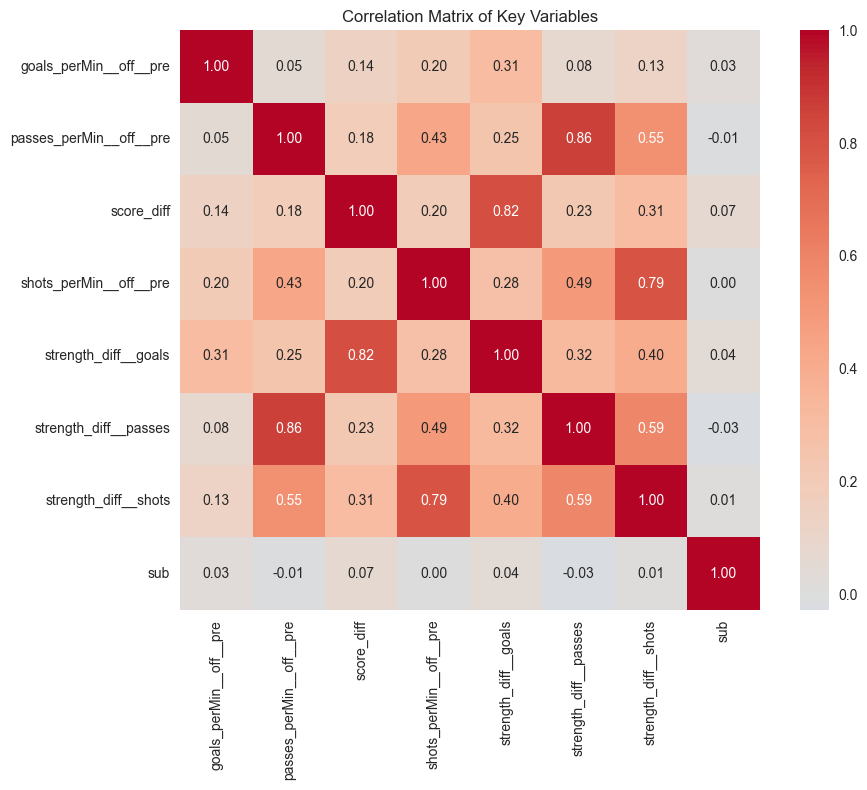

In [12]:
# =================================== 1.3 Inspect Correlations =================================== #


# --- Variables to inspect:
key_vars = list(np.unique(["sub","score_diff"] + [f'{o}_perMin__off__pre' for o in OUTCOMES] + [f'strength_diff__{o}' for o in OUTCOMES]))

# --- Correlation matrix of key variables:
correlation_matrix = df[key_vars].corr()

# --- Plot the Matrix:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(OUTPUT_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight")
    print("\nCorrelation matrix saved to output directory.")
plt.show()



In [13]:
# ================================== 1.4 Zooming in on Score Differential ================================== #

print(f"\nCorrelation between Score Differential & Treatment Assignment: {df["score_diff"].corr(df["sub"]):.3f}")

print("\nCorrelation between Score Differential & Outcomes:\n")
for outcome in [f'{o}_perMin__off__DIFF' for o in OUTCOMES]:
    corr = df["score_diff"].corr(df[outcome])
    print(f"{outcome}: {corr:.3f}")


Correlation between Score Differential & Treatment Assignment: 0.071

Correlation between Score Differential & Outcomes:

shots_perMin__off__DIFF: -0.001
goals_perMin__off__DIFF: -0.001
passes_perMin__off__DIFF: -0.048


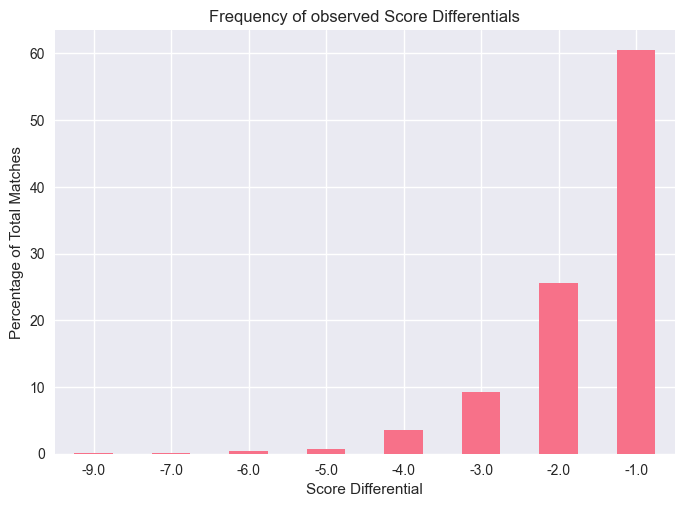

In [14]:
# ================================== 1.5 Distribution of Score Differentials ================================== #

# --- Count by Unique Match-ID:
df_plot = df.groupby(["score_diff",'match_id'])["sub"].sum().reset_index().copy()

(df_plot.groupby("score_diff")["sub"].count() / df_plot.shape[0] * 100).plot.bar(
    rot=0, ylabel="Percentage of Total Matches", title="Frequency of observed Score Differentials", xlabel="Score Differential"
);

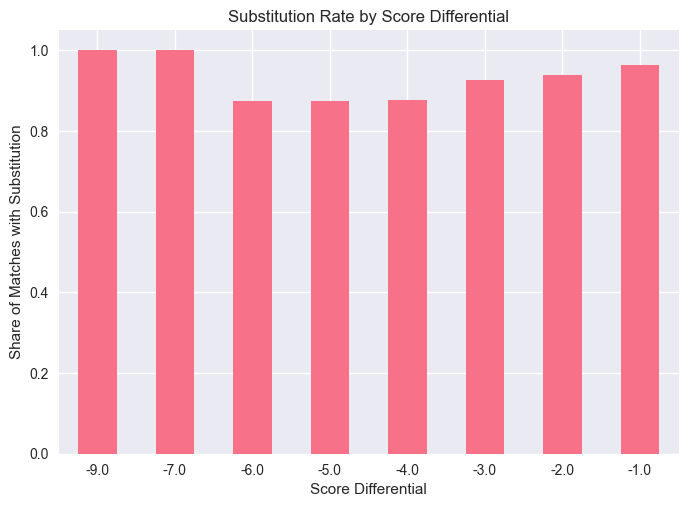

In [15]:
# ================================== 1.6 How does Substitution vary with Score Differential? ================================== #

# --- Count by Unique Match-ID:
df_plot = df.groupby(["score_diff",'match_id'])["sub"].sum().reset_index().copy()
df_plot['sub'] = np.where(df_plot['sub'] > 0 ,1,0)

(df_plot.groupby("score_diff")["sub"].sum() / df_plot.groupby("score_diff")["sub"].count()).plot.bar(
    rot=0, ylabel="Share of Matches with Substitution", title="Substitution Rate by Score Differential", xlabel="Score Differential"
);

<br>

## 2. &emsp; Wasserstein Generative Adversarial Network (WGAN)

In [16]:
df.columns

Index(['match_status', 'match_id', 'competition', 'season', 'team_off',
       'team_off__id', 'team_def', 'team_def__id', 'team_off__score60',
       'team_def__score60',
       ...
       'shots_target_Rate__def__post', 'interceptions_Rate__off__post',
       'interceptions_Rate__def__post', 'duel_Rate__off__post',
       'duel_Rate__def__post', 'dribble_Rate__off__post',
       'dribble_Rate__def__post', 'strength__off__post', 'strength__def__post',
       'strength_diff__post'],
      dtype='object', length=148)

In [208]:
# ======================================== USER INTERACTION ======================================== #

# --- Define your target: ---> these are the variables which will be simulated
Y_var = ['strength__off__post','strength__off__pre']
Y_var = ['score_diff']
Y_var = ['passes_perMin__off__post']

# --- Define your feature set: ---> these are the conditioning variables [None; list of features]
X_var = None


# --- --- Specify variables that shall be scaled:
var_scale = {'X':None,'Y':{'passes_perMin__off__post': 'standardize'}}
#var_scale = {'X':None,'Y':None}


# --- --- Specify variables that are categorical
categories_Y = []
#categories_Y = ['score_diff']



# --- --- Any bounds on continuous variables? [ [min,max] ]
bounds_dict = {'X':{},
               #'Y':{}
               #'Y':{'score_diff': [1,None]}
               #'Y':{'strength__off__post': [0,None],
               #     'strength__off__pre': [0,None]
               #    }
               #'Y':{'passes_perMin__off__post': [0,None]}
               'Y':{'passes_perMin__off__post': [-df['passes_perMin__off__post'].mean()/df['passes_perMin__off__post'].std(),None]}
              }




# ======================================== USER INTERACTION ======================================== #

In [209]:
# ==================================== Train- & Test-Set ================================== #

if X_var:
    df__noNA = df[X_var+Y_var].copy().dropna().reset_index(drop=True)
else:
    df__noNA = df[Y_var].copy().dropna().reset_index(drop=True)


# --- Features:
if X_var:
    Xtrain = df__noNA[X_var].copy()
else:
    Xtrain = pd.DataFrame(index=df__noNA.index)

# --- Target
Ytrain = df__noNA[Y_var].copy()
if 'score_diff' in Y_var:
    Ytrain['score_diff'] *= -1


# --- Scaling
dict__scaler = {'X':{'numerator':[0]*Xtrain.shape[1],
                     'denominator':[1]*Xtrain.shape[1]},
                'Y':{'numerator':[0]*Ytrain.shape[1],
                     'denominator':[1]*Ytrain.shape[1]}}


if var_scale['X']:


    for v in var_scale['Y'].keys():

        if var_scale['X'][v] == 'standardize':
            out__scaling = Scaler.standardize(Xtrain[v], verbose=False)
        elif var_scale['X'][v] == 'minmax':
            out__scaling = Scaler.minmax(Xtrain[v], verbose=False)

        Xtrain[v] = out__scaling['df']

        # --- Collect Scalers:
        idx_X = Xtrain.columns.tolist().index(v)
        dict__scaler['X']['numerator'][idx_X] = out__scaling['numerator']
        dict__scaler['X']['denominator'][idx_X] = out__scaling['denominator']




if var_scale['Y']:

    for v in var_scale['Y'].keys():

        if var_scale['Y'][v] == 'standardize':
            out__scaling = Scaler.standardize(Ytrain[v], verbose=False)
        elif var_scale['Y'][v] == 'minmax':
            out__scaling = Scaler.minmax(Ytrain[v], verbose=False)

        Ytrain[v] = out__scaling['df']

        # --- Collect Scalers:
        idx_Y = Ytrain.columns.tolist().index(v)
        dict__scaler['Y']['numerator'][idx_Y] = out__scaling['numerator']
        dict__scaler['Y']['denominator'][idx_Y] = out__scaling['denominator']



In [210]:
# ==================================== Set Up the Neural Network ================================== #


class Generator(torch.nn.Module):

    def __init__(self,params):
        super(Generator,self).__init__()
        
        # --- Get the index for the variable(s) to be simulated
        #self.idx_Y = params['idx_Y']
        
        # --- Get the index for the variable(s) to be conditioned on
        #self.idx_X = params['idx_X']
        
        # --- Declare bounds of continuous variables
        self.bounds = params['bounds_idx']
        
        # --- Declare the index of categorical variables
        self.categories = params['categories_idx']
        
        # --- Declare the number of layers (yes: input + hidden + output)
        self.n_layers = len(params['nodes'])
        
        # --- Declare the index for the hidden layers
        self.hidden_layers = range(2,self.n_layers-1)
        
        # --- Create the Architecture
        self.layers = torch.nn.ModuleDict()
        
        # --- --- Input-Layer
        self.layers['input'] = torch.nn.Linear(in_features=params['nodes'][0],out_features=params['nodes'][1])
        
        # --- --- Hidden-Layers
        for ll in self.hidden_layers:
          self.layers[f'hidden_{ll-1}'] = torch.nn.Linear(in_features=params['nodes'][ll-1],out_features=params['nodes'][ll])
        
        # --- --- Output-Layer
        #self.layers['output'] = torch.nn.Linear(in_features=params['nodes'][self.n_layers-2],out_features=params['nodes'][0])
        self.layers['output'] = torch.nn.Linear(in_features=params['nodes'][self.n_layers-2],out_features=params['nodes'][self.n_layers-1])



    
    def _transform(self,layer_orig):

        

        layer = torch.zeros([layer_orig.shape[0],len(self.categories.keys())], dtype=torch.float32)
        #layer = torch.zeros(layer_orig.shape, dtype=torch.float32)


        #print(self.categories['1'],layer_orig[:,self.categories['1']].shape, torch.argmax(layer_orig[:,self.categories['1']], dim=1))

        # --- Run the 'argmax' across all categorical features:
        for ii in list(self.categories.keys()):

            ii_int = int(ii)   

            if len(self.categories[ii]) > 1:
                layer[:,ii_int] = torch.argmax(layer_orig[:,self.categories[ii]], dim=1).clone().detach()
                #layer[:,self.categories[ii]] = torch.softmax(layer_orig[:,self.categories[ii]], dim=-1).clone().detach().requires_grad_(True)
            else:
                layer[:,ii_int] = layer_orig[:,self.categories[ii][0]].clone().detach().requires_grad_(True)
                
            
    
        

        if len(self.bounds) > 0:
          for ii in list(self.bounds.keys()):

            ii_int = int(ii)
    
            layer[:,ii_int] = torch.clamp(layer[:,ii_int].clone(),min=self.bounds[ii][0],max=self.bounds[ii][1])
    
            if 1==2:
    
              ii_T = layer.shape[0]
              ii_N = layer.shape[1]
    
              if ii_int == 0:
                layer = torch.hstack((torch.clamp(layer[:,ii_int],min=self.bounds[ii][0],max=self.bounds[ii][1]).resize_(ii_T,ii_N-1),
                                      layer[:,(ii_int+1):]))
              elif ii_int == (layer.shape[1]-1):
                layer = torch.hstack((layer[:,:ii_int],
                                      torch.clamp(layer[:,ii_int],min=self.bounds[ii][0],max=self.bounds[ii][1]).resize_(ii_T,1)))
              else:
                layer = torch.hstack((layer[:,:ii_int].resize_(ii_T,ii_N-ii_int),
                                      torch.clamp(layer[:,ii_int],min=self.bounds[ii][0],max=self.bounds[ii][1]).resize_(ii_T,1),
                                      layer[:,(ii_int+1):].resize_(ii_T,ii_N-ii_int)))

        #print(layer)
        
        return layer #torch.tensor(layer, requires_grad=True)


    def forward(self,x):
        x = torch.nn.functional.leaky_relu(self.layers['input'](x), 0.2)
        #x = torch.nn.functional.dropout(x,params['dropout_p']['G'])
        
        for ll in self.hidden_layers:
            x = torch.nn.functional.dropout(x,params['dropout_p']['G'])
            x = torch.nn.functional.leaky_relu(self.layers[f'hidden_{ll-1}'](x), 0.2)
            
        
        #return self.layers['output'](x)
        return self._transform(self.layers['output'](x))



class Discriminator(torch.nn.Module):

    def __init__(self,params):
        super(Discriminator,self).__init__()
        
        # --- Declare the number of layers (yes: input + hidden + output)
        self.n_layers = len(params['nodes'])
        
        # --- Declare the index for the hidden layers
        self.hidden_layers = range(2,self.n_layers-1)
        
        # --- Create the Architecture
        self.layers = torch.nn.ModuleDict()
        
        # --- --- Input-Layer
        self.layers['input'] = torch.nn.Linear(in_features=params['nodes'][0],out_features=params['nodes'][1])
        
        # --- --- Hidden-Layers
        for ll in self.hidden_layers:
          self.layers[f'hidden_{ll-1}'] = torch.nn.Linear(in_features=params['nodes'][ll-1],out_features=params['nodes'][ll])
        
        # --- --- Output-Layer
        #self.layers['output'] = torch.nn.Linear(in_features=params['nodes'][self.n_layers-2],out_features=params['nodes'][self.n_layers-1])
        self.layers['output'] = torch.nn.Linear(in_features=params['nodes'][self.n_layers-2],out_features=params['nodes'][0])
        
    
    def forward(self,x):
        x = torch.nn.functional.leaky_relu(self.layers['input'](x), 0.2)
        #x = torch.nn.functional.dropout(x,params['dropout_p']['D'])
        
        for ll in self.hidden_layers:
            x = torch.nn.functional.dropout(x,params['dropout_p']['D'])
            x = torch.nn.functional.leaky_relu(self.layers[f'hidden_{ll-1}'](x), 0.2)
            
        
        return self.layers['output'](x)




def plot__TrainValError(values_Train,values_Val,error_label):
    
    # --- Plot Iterations:
    XX = len(values_Train)
    
    plot_df = pd.DataFrame({'Iteration':np.arange(0,XX)+1,'WD (Train)': values_Train,'WD (Val)':values_Val})

    
    fig, ax = plt.subplots(figsize=(8,5))
    sns.lineplot(x=plot_df.loc[:XX,'Iteration'], y=plot_df.loc[:XX,'WD (Train)'],label='Train Error',color='darkgreen',ax=ax)
    sns.lineplot(x=plot_df.loc[:XX,'Iteration'], y=plot_df.loc[:XX,'WD (Val)'],label = 'Validation Error',color='firebrick',ax=ax)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel(error_label)
    plt.show()
    
    print('\n\nEpoch with lowest Validation-MSE: ' + str(values_Val.index(min(values_Val))) + ' out of ' + str(XX))

# ==================================== Set Up the Neural Network ================================== #

In [211]:
# --------------------------- 5.1   Define the Matrices  --------------------------- #

# ----> USE ALL DATA FOR TRAINING
tt_Xtrain = torch.tensor(Xtrain.values, dtype=torch.float32)
tt_Ytrain = torch.tensor(Ytrain.values, dtype=torch.float32).reshape(Ytrain.shape[0],Ytrain.shape[1])


#if Y_var == categories_Y:
#    tt_Ytrain = torch.nn.functional.one_hot(torch.Tensor.long(tt_Ytrain.view(-1)))


tt_data_train = torch.concat([tt_Ytrain,tt_Xtrain],axis=1)

# --- Get the index for the variables with lower bounds
bounds_idx = {}
for ll in list(bounds_dict['Y'].keys()):

  idx = np.where(Ytrain.columns == ll)[0][0]
  bounds_idx[str(idx)] = bounds_dict['Y'][ll]

for ll in list(bounds_dict['X'].keys()):

  idx = np.where(Xtrain.columns == ll)[0][0] + Ytrain.shape[1]
  bounds_idx[str(idx)] = bounds_dict['X'][ll]



# --- Collect the index for Categorical Variables & Total Number of Output-Nodes:
categories_idx = {}
nodes_outputLayer = 0
for f in Ytrain.columns:

    # --- Index of the feature:
    idx = Ytrain.columns.tolist().index(f)
    
    if f in categories_Y:

        # ----------------- IN CASE OF ONE-HOT-ENCODING CATEGORICAL VARIABLES ----------------- #
        # --- Index of the feature's categories in the output-layer
        #categories_idx[str(idx)] = np.arange(nodes_outputLayer,nodes_outputLayer+tt_Ytrain.shape[1]).tolist()
        # --- Add Output-Nodes:
        #nodes_outputLayer += tt_Ytrain.shape[1]


        # --- Index of the feature's categories in the output-layer
        categories_idx[str(idx)] = np.arange(nodes_outputLayer,nodes_outputLayer+len(Ytrain[ll].unique())).tolist()
        # --- Add Output-Nodes:
        nodes_outputLayer += len(Ytrain[ll].unique())
        
    else:
        # --- Index of the feature's categories in the output-layer
        categories_idx[str(idx)] = np.arange(nodes_outputLayer,nodes_outputLayer+1).tolist()
        # --- Add Output-Nodes:
        nodes_outputLayer += 1
        
    


In [219]:
# ==================================== USER INTERACTION: Define the Network Architecture ================================== #

# --- Set the number of nodes per layer: a vector with integers
#nodes_vec = [tt_data_train.shape[1],512,128,32,len(Y_var)]
nodes_vec = [tt_data_train.shape[1],128,128,128,nodes_outputLayer]
#nodes_vec = [tt_data_train.shape[1],32,32,32,nodes_outputLayer]
#nodes_vec = [tt_data_train.shape[1],1024,nodes_outputLayer]



# --- Set dropout-probability:
dropout_p = {'G':0.2,'D':0.0}

# --- Set the Learning-Rate:
learning_rate = 0.0005

# --- Set the penalty for the derivative of the critic:
penalty = 5

# --- Set the Batch-Size:
batch_size = min(512,tt_data_train.shape[0])
batch_size = 32


# --- Set the number of epochs:
n_epochs = 1000

# --- Set the number of iterations for training the 'critic' before training the 'generator':
n_critic = 15

# --- Burn-In epochs from when on to start determining the best iteration:
burn_in = 20


# ==================================== USER INTERACTION: Define the Network Architecture ================================== #



# ------------------------------------ 5.2   Set the Model  -------------------------------------------- #

# --- Type of Distribution for generating noise: ['normal','uniform']
Dtype = 'normal'

# --- Scaler & Bias of the Distribution:
mu_Normal = 0 #tt_Ytrain.mean()
sd_Normal = 20



# --- 5.2.1   Pack the parameters
params = dict({'nodes':nodes_vec,'dropout_p':dropout_p,'categories_idx':categories_idx,'bounds_idx':bounds_idx,
               'idx_Y':list(range(tt_Ytrain.shape[1])),
               'idx_X':list(range(tt_Ytrain.shape[1],tt_Ytrain.shape[1]+tt_Xtrain.shape[1]))})

# --- 5.2.2   Set the Model
#WGAN_g = Generator(params)
#WGAN_c = Discriminator(params)
print(Generator(params))
#print(Discriminator(params))

Generator(
  (layers): ModuleDict(
    (input): Linear(in_features=1, out_features=128, bias=True)
    (hidden_1): Linear(in_features=128, out_features=128, bias=True)
    (hidden_2): Linear(in_features=128, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=1, bias=True)
  )
)


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.97it/s]


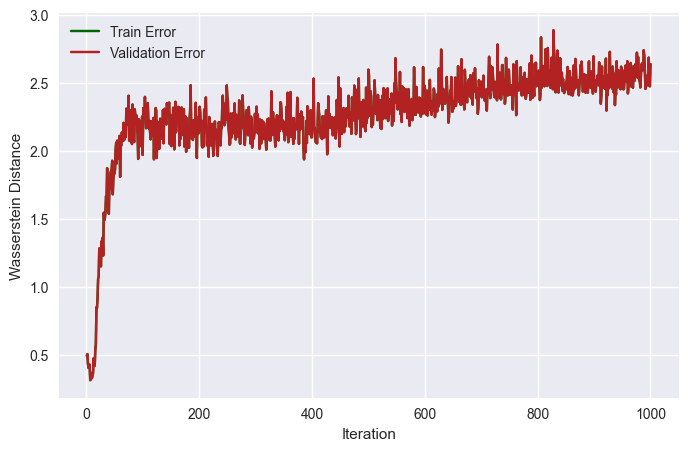



Epoch with lowest Validation-MSE: 6 out of 1000




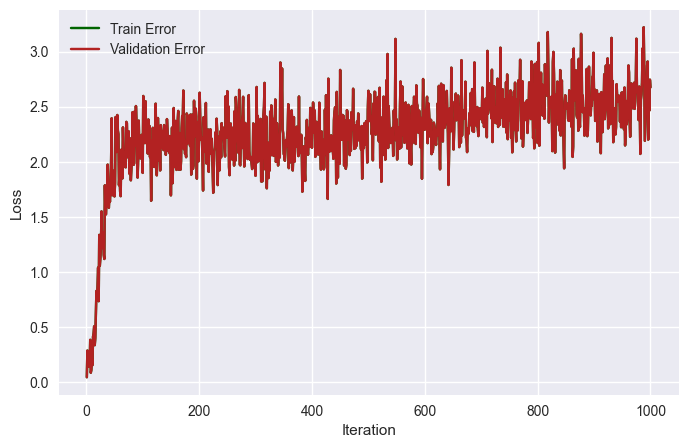



Epoch with lowest Validation-MSE: 0 out of 1000
Fitting Done! --- Best Epoch: 21


In [220]:
# ------------------------------------ 5.3   Train the Model  -------------------------------------------- #


torch.manual_seed(123)
np.random.seed(123)

WGAN_g = Generator(params)
WGAN_c = Discriminator(params)

def get__Noise(size,mean,sd,Dtype):

    if Dtype == 'normal':
        return torch.randn(size) * sd + mean
    if Dtype == 'uniform':
        return torch.rand(size) * sd + mean

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

WGAN_g.apply(weights_init)
WGAN_c.apply(weights_init)


WD_train, WD_val, Q_c_vec, vec_e = [], [], [], []

# --- 5.3.1   Define the Optimization-Algorithms for Generator & Critic
optim_g = torch.optim.Adam(WGAN_g.parameters(), lr=learning_rate, betas=(0.0, 0.9))
optim_c = torch.optim.Adam(WGAN_c.parameters(), lr=learning_rate, betas=(0.0, 0.9))

# --- 5.3.1   Define the Loss Function
loss_function = torch.nn.MSELoss()


# --------------------------------------------- Start the Training Loop ------------------------------------- #


# --- 5.3.1   Dimension of the variables to be simulated
NN, FF = tt_Ytrain.shape


counter = 0
for ee in tqdm(range(n_epochs)):

    WGAN_c.train()
    WGAN_g.train()


    # --- 5.3.2 Train the critic
    for nc in range(n_critic):

        # --- --- Critic Update:
        for par in WGAN_c.parameters():
            par.requires_grad = True
        for par in WGAN_g.parameters():
            par.requires_grad = False
        
        optim_c.zero_grad()
    
        # --- --- 5.3.2.1 Sample a batch of size 'batch_size' from the 'real' features & targets (without replacement)
        idx_bb = np.random.choice(np.arange(tt_Xtrain.shape[0]),size=batch_size,replace=False)
        Xtrain_bb = tt_Xtrain[idx_bb,:]
        Ytrain_bb = tt_Ytrain[idx_bb,:]
        data_train_bb = torch.concat([Ytrain_bb,Xtrain_bb],axis=1)
        
        # --- --- 5.3.2.2 Sample a batch of random noise from a Multivariate Gaussian: mean=0;cov=identity (FF x FF)
        #Ztrain_bb = torch.concat([torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros(FF), covariance_matrix=torch.eye(FF)).rsample((batch_size,)),X_train_bb],axis=1)
        Ztrain_bb = torch.concat([get__Noise((batch_size,FF),mu_Normal,sd_Normal,Dtype),Xtrain_bb],axis=1)
        
        
        # --- --- 5.3.2.3 Generate Fake-Observations from the noise data ---> feed noise into the 'Generator'
        Xhat = WGAN_g(Ztrain_bb)


        
        # --- --- 5.3.2.4 Add the penalty
        # --- --- --- --- --- make the convex combination ('X_hat')
        epsilon = torch.rand(Xhat.shape[0]).unsqueeze(1)
        Xhat_for_penalty = epsilon*Ytrain_bb + (1-epsilon)*Xhat[:,params['idx_Y']]
        
        # --- --- --- --- --- gradient of the output from 'WGAN_c(X_hat)' with respect to the inputs 'X_hat'
        Xhat_for_penalty = torch.autograd.Variable(Xhat_for_penalty.detach(),requires_grad=True)
        critic_Xhat = WGAN_c(torch.concat([Xhat_for_penalty,Xtrain_bb],axis=1))
        g_inputs = torch.autograd.grad(critic_Xhat, Xhat_for_penalty,
                                       torch.ones_like(critic_Xhat),
                                       retain_graph=True, create_graph=True, only_inputs=True)[0]
        #Q_c = torch.mean(torch.maximum(torch.zeros(g_inputs.shape[0]), torch.sum(g_inputs**2,axis=1)**0.5 - 1)**2)
        Q_c = torch.nn.functional.relu(g_inputs.norm(2, dim=1) - 1).mean()  
        Q_c_vec.append(Q_c.detach().numpy())


        
        # --- --- 5.3.2.5 Calculate the loss of the 'Critic'
        #loss_c = - (-loss_function(Ytrain_bb,WGAN_c(data_train_bb_fake)) + loss_function(Ytrain_bb,WGAN_c(Xtrain_bb)) + penalty * Q_c)
        #loss_c = ((Ytrain_bb-WGAN_c(data_train_bb_fake))**2).mean() - ((Ytrain_bb-WGAN_c(Xtrain_bb))**2).mean() + penalty * Q_c
        #loss_c =  WGAN_c(data_train_bb_fake).mean() - WGAN_c(Xtrain_bb).mean() + penalty * Q_c
        loss =  WGAN_c(torch.concat([Xhat,Xtrain_bb],axis=1)).mean() - WGAN_c(data_train_bb).mean() + penalty * Q_c

        #print(loss_c)
        
        loss.backward()
        optim_c.step()
        
        
    # --- 5.3.3         After having trained the 'Critic' for 'n_critic' iterations in epoch 'ee', update the generator
    optim_g.zero_grad()

    # --- --- Generator Update:
    for par in WGAN_c.parameters():
        par.requires_grad = False
    for par in WGAN_g.parameters():
        par.requires_grad = True
    
    # --- --- 5.3.3.1   Sample a batch of size 'batch_size' from the real targets (without replacement)
    idx = np.random.choice(np.arange(NN),size=(batch_size,),replace=False)
    Ytrain_bb = tt_Ytrain[idx,:]
    Xtrain_bb = tt_Xtrain[idx,:]
    
    # --- --- 5.3.3.2   Sample a batch of random noise from a Multivariate Gaussian: mean=0;cov=identity (FF x FF)
    #Z_train_bb = torch.concat([torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros(FF), covariance_matrix=torch.eye(FF)).rsample((batch_size,)),Xtrain_bb],axis=1)
    Ztrain_bb = torch.concat([get__Noise((batch_size,FF),mu_Normal,sd_Normal,Dtype),Xtrain_bb],axis=1)
    
    # --- --- 5.3.2.4   Calculate the loss of the 'Generator'
    #loss_g = (- loss_function(Ytrain_bb,WGAN_c(WGAN_g(Ztrain_bb))))
    loss = - WGAN_c(torch.cat([WGAN_g(Ztrain_bb),Xtrain_bb],dim=1)).mean()
    
    loss.backward()
    optim_g.step()

    vec_e.append(loss.item())
    
    
    # --- 5.3.4   Calculate Training- & Validation-Error
    WGAN_c.eval()
    WGAN_g.eval()

    
    # --- --- --- 5.3.4.1   Sample a batch of random noise from a Multivariate Gaussian: mean=0;cov=identity (FF x FF)
    #Z = torch.concat([torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros(FF), covariance_matrix=torch.eye(FF)).rsample((N_surrogates,)),tt_X_train],axis=1)
    idx = np.arange(Ytrain.shape[0]) #np.random.choice(np.arange(0,Ytrain.shape[0]),size=(N_surrogates,),replace=True)
    Z = torch.concat([get__Noise((len(idx),FF),mu_Normal,sd_Normal,Dtype),tt_Xtrain[idx,:]],axis=1)
    
    # --- --- --- 5.3.4.2   Compute the Wasserstein-Distance ('Earth-Mover'-Distance)
    with torch.no_grad():
        Y_s = WGAN_c(torch.cat([WGAN_g(Z),tt_Xtrain[idx,:]], dim=1)).detach().numpy().flatten()
        Y_real = tt_Ytrain[idx,:].detach().numpy().flatten()
    WD_train.append(wasserstein_distance(Y_s,Y_real))
    
    # --- --- --- ---       Training-Error == Validation-Error
    WD_val.append(WD_train[-1])


    
    
    
    
    # --- Save the model that performs best across epochs
    if ee == burn_in:
      model_star = {'WGAN_c':copy.deepcopy(WGAN_c), 'WGAN_g':copy.deepcopy(WGAN_g)}
      epoch_star = ee
    elif ee > burn_in:
      if vec_e[-1] < min(vec_e[burn_in:-1]):
          model_star = {'WGAN_c':copy.deepcopy(WGAN_c), 'WGAN_g':copy.deepcopy(WGAN_g)}
          epoch_star = ee
    
    
    counter += 1




plot__TrainValError(WD_train,WD_val,error_label='Wasserstein Distance')
print('\n')
plot__TrainValError(vec_e,vec_e,error_label='Loss')



print(f'Fitting Done! --- Best Epoch: {epoch_star}')

In [221]:
# ============================================== 5.4   Generate Surrogate-Data ============================================== #

# ------------------------------------------ 5.4.0 USER INTERACTION ------------------------------------------ #

# --- How many surrogate samples do you want?
N_surrogates = 10000

# ------------------------------------------ 5.4.0 USER INTERACTION ------------------------------------------ #

# --- 5.4.0.0   Unpack the optimal model
WGAN_c = model_star['WGAN_c']
WGAN_g = model_star['WGAN_g']


WGAN_g.eval()
WGAN_c.eval()

# ------------------------------------------- 5.4.1   From WGAN ----------------------------------------------- #

# --- 5.4.1.1   Sample a batch of random noise from a Multivariate Gaussian: mean=0;cov=identity (FF x FF)
#Z = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros(FF), covariance_matrix=torch.eye(FF)).rsample((N_surrogates,))
idx = np.random.choice(np.arange(0,Ytrain.shape[0]),size=(N_surrogates,),replace=True)
Z = torch.concat([get__Noise((N_surrogates,FF),mu_Normal,sd_Normal,Dtype),tt_Xtrain[idx,:]],axis=1)
#Z = torch.concat([tt_Ytrain[idx,:],tt_Xtrain[idx,:]],axis=1)

# --- 5.4.1.2   Generate Surrogate data:
with torch.no_grad():
    data_s = WGAN_g(Z)
    #data_s = WGAN_c(Z)
X_s = pd.DataFrame(data_s[:,len(params['idx_Y']):].detach().numpy(),columns=Xtrain.columns)

#if Y_var == categories_Y:
#    Y_s = pd.DataFrame(torch.argmax(data_s[:,:len(params['idx_Y'])], dim=-1).detach().numpy(),columns=Ytrain.columns)
#else:
#    Y_s = pd.DataFrame(data_s[:,:len(params['idx_Y'])].detach().numpy(),columns=Ytrain.columns)
Y_s = pd.DataFrame(data_s[:,:len(params['idx_Y'])].detach().numpy(),columns=Ytrain.columns)


#Y_s = pd.DataFrame(WGAN_c(data_s).detach().numpy(),columns=Ytrain.columns)


In [222]:
with torch.no_grad():
    test = WGAN_c(Z)

pd.Series(test.detach().numpy().flatten()).describe()

count    10000.000000
mean        -5.293223
std         10.001280
min        -60.597504
25%        -10.800419
50%         -0.426858
75%          1.826980
max         10.188247
dtype: float64

In [223]:
# ======================================== 5.5.1   Wasserstein Distance for each feature ======================================== #

WD_features = pd.DataFrame({'WD (Surrogate: raw)':np.zeros((Y_s.shape[1],)),
                            'WD Rank (Surrogate: raw)':np.zeros((Y_s.shape[1],)),
                            'WD (Surrogate: rescaled)':np.zeros((Y_s.shape[1],)),
                            'WD Rank (Surrogate: rescaled)':np.zeros((Y_s.shape[1],)),},
                           index=Ytrain.columns)


for ff in range(Y_s.shape[1]):

    # --- Name of the Feature:
    ff_name = Y_s.columns[ff]

    # --- Surrogate Feature: raw
    feature_raw = Y_s[ff_name]
    
    # --- Surrogate Feature: rescaled
    feature_rescaled = Y_s[ff_name] * dict__scaler['Y']['denominator'][ff] + dict__scaler['Y']['numerator'][ff]
    
    # --- Calculate the Wasserstein Distance:
    WD_features.loc[ff_name,'WD (Surrogate: raw)'] = np.round(wasserstein_distance(feature_raw,Ytrain[ff_name]),3)
    WD_features.loc[ff_name,'WD (Surrogate: rescaled)'] = np.round(wasserstein_distance(feature_rescaled,Ytrain[ff_name]),3)
    

WD_features['WD Rank (Surrogate: raw)'] = WD_features['WD (Surrogate: raw)'].argsort().argsort().values
WD_features['WD Rank (Surrogate: rescaled)'] = WD_features['WD (Surrogate: rescaled)'].argsort().argsort().values
WD_features

,WD (Surrogate: raw),WD Rank (Surrogate: raw),WD (Surrogate: rescaled),WD Rank (Surrogate: rescaled)
passes_perMin__off__post,0.404,0,4.891,0


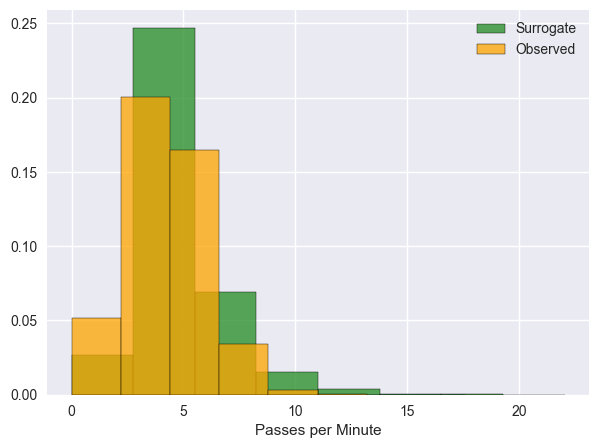


Wasserstein Distance (Surrogate: raw):  3.781

Wasserstein Distance (Surrogate: rescaled):  0.696


In [229]:
# ======================================== 5.6   Plot Distributions for some Variables ======================================== #


# ---------------------------- USER INTERACTION ---------------------------- #

# --- Name of the variable you want to plot:
name_var = 'score_diff'
name_var = 'passes_perMin__off__post'


# ---------------------------- USER INTERACTION ---------------------------- #


# --- Index of Variable:
idx_var = Y_s.columns.tolist().index(name_var)

# --- --- --- Select an index:
idx = np.random.choice(np.arange(0,Y_s.shape[0]),np.min([Y_s.shape[0],Ytrain.shape[0]]),replace=False)

# --- --- --- Re-Scale
Y_s_picked_rescaled = Y_s.loc[idx,name_var] * dict__scaler['Y']['denominator'][idx_var] + dict__scaler['Y']['numerator'][idx_var]
Ytrain_rescaled = Ytrain[name_var] * dict__scaler['Y']['denominator'][idx_var] + dict__scaler['Y']['numerator'][idx_var]


# --- --- --- Plot:
fig, ax = plt.subplots(1,1, figsize=(7,5))
#sns.histplot(Y_s.loc[idx,name_var], color='skyblue', kde=True,bins=5)
sns.histplot(Y_s_picked_rescaled.values, color='forestgreen', kde=False,bins=8, ax=ax, stat='density')
sns.histplot(Ytrain_rescaled.values, color='orange', kde=False,bins=8,ax=ax, stat='density')
#ax.set_xlabel(name_var)
ax.set_xlabel('Passes per Minute')
ax.set_ylabel('')
#plt.legend(labels=['Surrogate (raw)','Surrogate (rescaled)','Observed'],title='',loc='upper left')
#plt.legend(labels=['Surrogate (rescaled)','Observed'],title='',loc='upper right')
plt.legend(labels=['Surrogate','Observed'],title='',loc='upper right')
plt.show()

print('\nWasserstein Distance (Surrogate: raw): ', str(np.round(wasserstein_distance(Y_s.loc[idx,name_var],
                                                                  Ytrain_rescaled),3)))
print('\nWasserstein Distance (Surrogate: rescaled): ', str(np.round(wasserstein_distance(Y_s_picked_rescaled,
                                                                  Ytrain_rescaled),3)))



if 1==2:
    fig.savefig(f'{directory}/20_figures/WGAN__PPM.png')

In [225]:
pd.DataFrame({'simul':Y_s_picked_rescaled.loc[idx].values,'obs':Ytrain_rescaled}).describe()

,simul,obs
count,4950.000000,4950.000000
mean,4.869992,4.172528
std,1.979452,1.778855
min,0.000422,0.000000
25%,3.998123,3.066667
50%,4.446770,4.145503
75%,5.479087,5.263158
max,21.671949,17.600000
